In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import scipy.io as scio
import h5py
import numpy as np
import time
import math
import os
import json
from pathlib import Path

dtype = torch.float
device_data = torch.device('cpu')
device_test = torch.device('cuda:0')
# evaluate the model by calculating the MSE of each curve
def evaluate(model, Input, Output):
    model.eval()
    with torch.no_grad():
        Output_pred = model(Input)
        loss_mat = (Output_pred - Output) ** 2
        loss = torch.mean(loss_mat, dim=1)
        return loss.cpu().numpy(), Output_pred.cpu().numpy()
    
def n_parameters(model:nn.Module):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [11]:
model_folder = Path(r'./nets/fnet/BASELINE_L20_R5.0_T10-400_NOISELESS/')

fnet:nn.Module = torch.load(model_folder/'fnet.pkl')

print('n_para:',n_parameters(fnet))

fnet.to(device_test)

with open(model_folder/'config.json',encoding='utf-8') as f:
    config = json.load(f)

train_data_path = Path(r'data\coatings\L20_R5.0_T10-400_1M.mat')
test_data_path = Path(r'data\coatings\L20_R5.0_T10-400_50K.mat')

fc = config['fnet']

wl = np.arange(fc['StartWL'], fc['EndWL'], fc['Resolution'])


train_data = scio.loadmat(train_data_path)
Input_train = torch.tensor(train_data['d'][:fc['TestingDataSize']], device=device_data, dtype=dtype)
Output_train = torch.tensor(train_data['T'][:fc['TestingDataSize']], device=device_data, dtype=dtype)

test_data = scio.loadmat(test_data_path)
Input_test = torch.tensor(test_data['d'], device=device_data, dtype=dtype)
Output_test = torch.tensor(test_data['T'], device=device_data, dtype=dtype)

n_para: 2191121


In [5]:
test_loss, test_Output_pred = evaluate(fnet, Input_test.to(device_test), Output_test.to(device_test))
train_loss, train_Output_pred = evaluate(fnet, Input_train.to(device_test), Output_train.to(device_test))
print('train loss: ', np.mean(train_loss))
print('test loss: ', np.mean(test_loss))


train loss:  0.013797759
test loss:  0.014365208


In [25]:
from thop import profile

flops, params = profile(fnet, inputs=(Input_test[[0]].to(device_test),))

print(f"flops: {flops:e}, params: {params}")

[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm1d'>.
[INFO] Register count_relu() for <class 'torch.nn.modules.activation.LeakyReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
flops: 4.388800e+06, params: 2191121.0


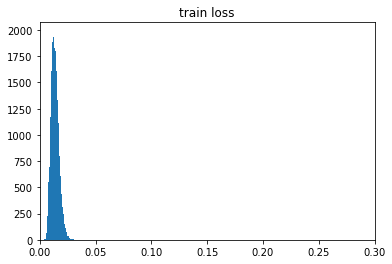

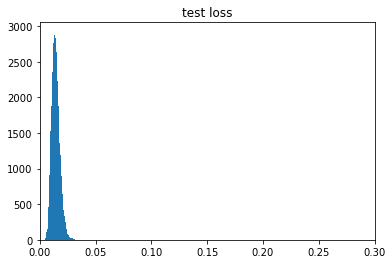

In [6]:
plt.hist(train_loss, bins=100)
plt.xlim(0, 0.3)
plt.title('train loss')
plt.show()
plt.hist(test_loss, bins=100)
plt.xlim(0, 0.3)
plt.title('test loss')
plt.show()

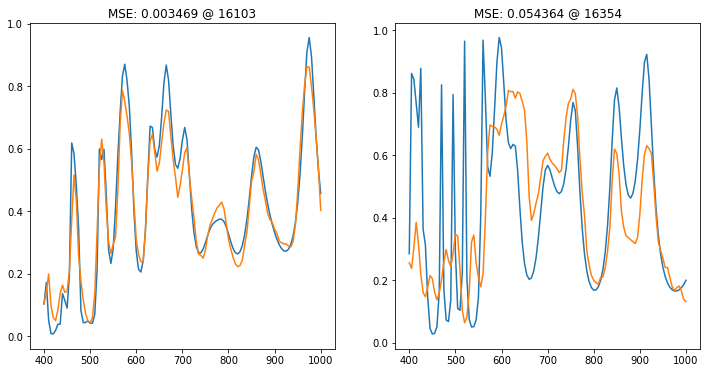

In [7]:
worst = np.argmax(test_loss)
plt.figure(figsize=(12,6))
plt.subplot(1,2,2)
plt.plot(wl,Output_test[worst].cpu().numpy())
plt.plot(wl,test_Output_pred[worst])
plt.title(f'MSE: {test_loss[worst]:.6f} @ {worst}')

best = np.argmin(test_loss)
plt.subplot(1,2,1)
plt.plot(wl,Output_test[best].cpu().numpy())
plt.plot(wl,test_Output_pred[best])
plt.title(f'MSE: {test_loss[best]:.6f} @ {best}')
plt.show()

In [5]:
Input_test[worst].sum()

NameError: name 'worst' is not defined

In [7]:
diff = np.abs(train_data['T'][1:] - train_data['T'][:-1])
std = np.std(train_data['T'], axis=1)
print(np.mean(diff),np.mean(std))

0.30709544 0.26836726


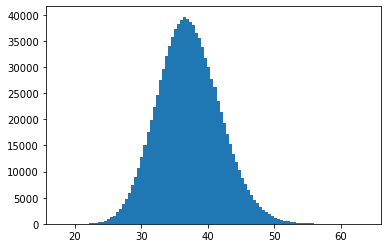

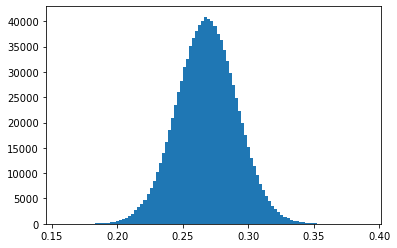

In [8]:
plt.hist(diff.sum(axis=1),bins=100)
plt.show()
plt.hist(std,bins=100)
plt.show()

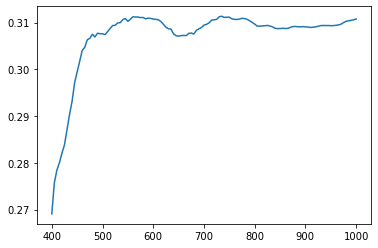

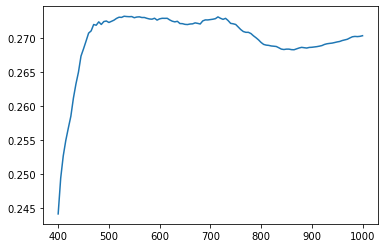

In [9]:
plt.plot(wl, diff.mean(axis=0))
plt.show()
plt.plot(wl, np.std(train_data['T'], axis=0))
plt.show()

(200, 20)


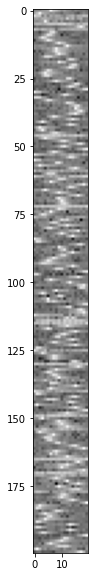

(200,)
(200,)
(200,)
(800, 200)


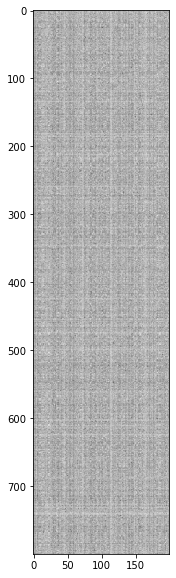

(800,)
(800,)
(800,)
(800, 800)


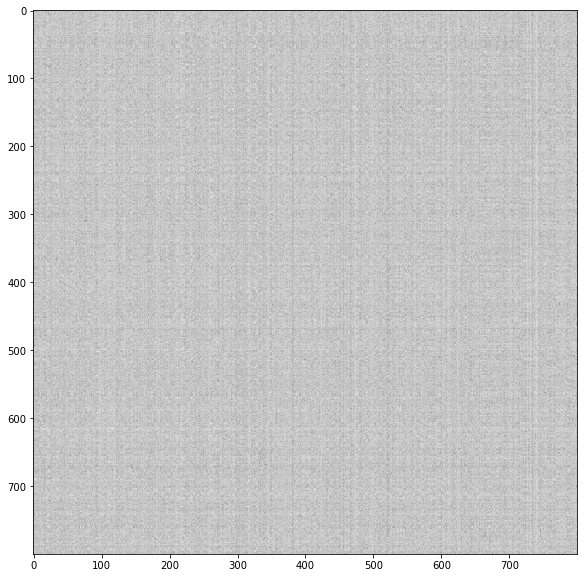

(800,)
(800,)
(800,)
(800, 800)


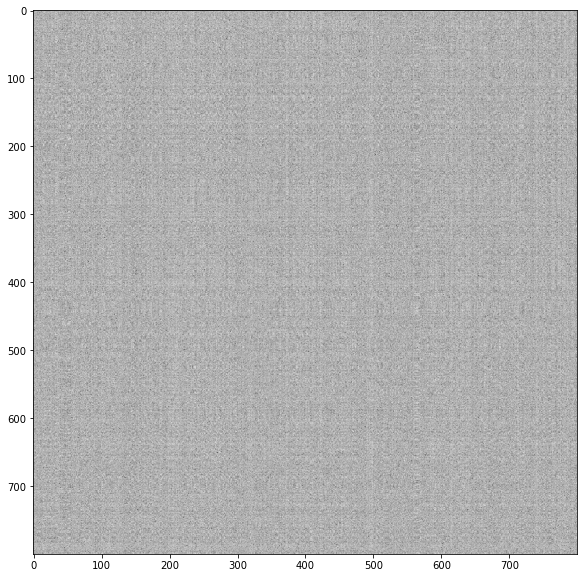

(800,)
(800,)
(800,)
(800, 800)


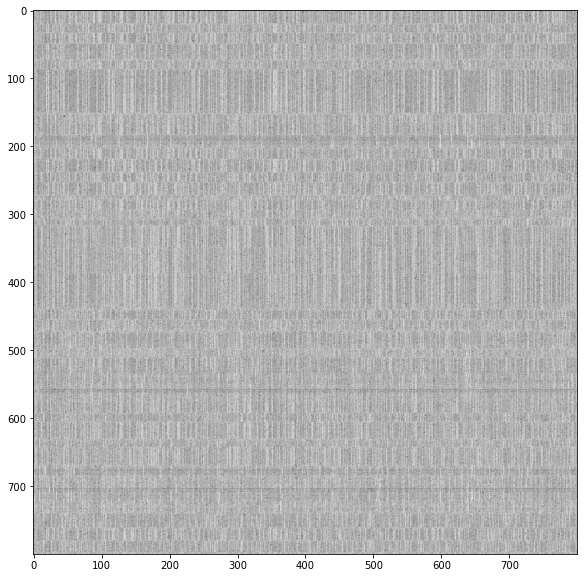

(800,)
(800,)
(800,)
(1, 1, 101)
(1,)
(1,)
(1,)
(1, 1, 75)
(1,)
(1,)
(1,)
(1, 1, 51)
(1,)
(1,)
(1,)
(1, 1, 25)
(1,)
(1,)
(1,)
(1, 1, 15)
(1,)
(1,)
(1,)
(1, 1, 7)
(1,)
(121, 800)


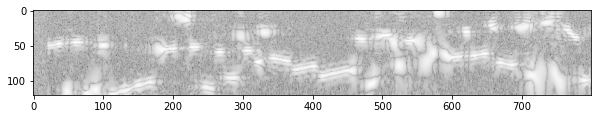

(121,)


In [11]:
for l in fnet.parameters():
    l:np.ndarray = l.cpu().detach().numpy()
    print(l.shape)
    if len(l.shape) >1 and len(l.shape) < 3:
        plt.figure(figsize=(10,10))
        plt.imshow(np.log(np.abs(l)),cmap='gray')
        plt.show()